# Base Rate Neglect K-means Clustering Analysis

In [1]:
#!pip install yellowbrick 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

## Import data

In [4]:
df = pd.read_csv("/Users/joey/Desktop/Woodman Scholar RA/BRN Clustering Project/treatment_data.csv") ##Replace filepath!
df

,dataset,unique_id,round,pc,pd
0,1,1001,1,20,80
1,1,1001,2,20,80
2,1,1001,3,20,80
3,1,1001,4,20,80
4,1,1001,5,20,80
...,...,...,...,...,...
16055,8,8100,16,5,95
16056,8,8100,17,5,95
16057,8,8100,18,5,95
16058,8,8100,19,5,95


## Calculate averages across trials

In [7]:
cols = ['dataset', 'unique_id', 'pc', 'pd']
average_df = df[cols].groupby('unique_id').mean()
print(average_df.describe())

          dataset          pc          pd
count  803.000000  803.000000  803.000000
mean     4.494396   16.848755   47.829888
std      2.296784   12.866374   24.790680
min      1.000000    0.000000    1.050000
25%      2.000000    7.750000   28.875000
50%      4.000000   15.000000   45.800000
75%      7.000000   20.000000   72.125000
max      8.000000   81.500000   97.600000


## Run elbow method to determine optimal amount of clusters on combined dataset

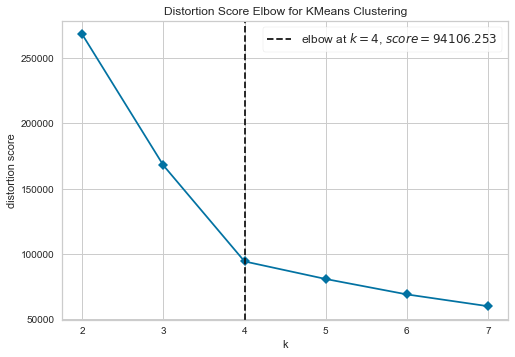

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
## taken from https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, locate_elbow = True, k=(2,8), timings=False)

visualizer.fit(average_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Run Elbow Method on Treatments 1 - 4

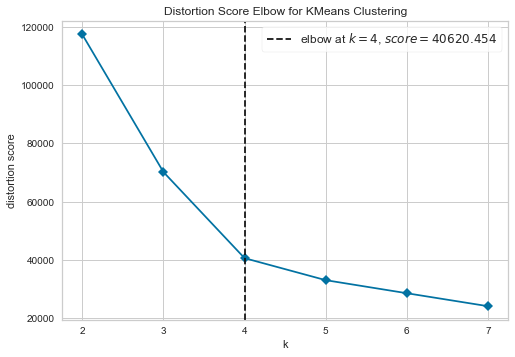

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
trials_one_to_four = average_df[average_df["dataset"] <= 4.0] 

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, locate_elbow = True, k=(2,8), timings=False)

visualizer.fit(trials_one_to_four)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Run Elbow Method on Treatments 5 - 8

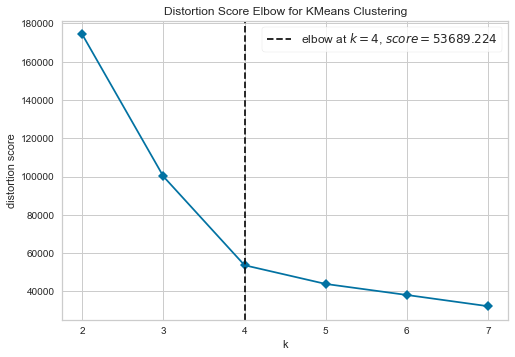

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
trials_five_to_eight = average_df[average_df["dataset"] >= 4.0] 

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, locate_elbow = True, k=(2,8), timings=False)

visualizer.fit(trials_five_to_eight)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Here we use the elbow method to determine the optimal number of clusters to partition our data into. The elbow method works by comparing the amount of 'distortion' between different numbers of clusters. Distortion is defined as the sum of square errors from each data point in the cluster to the centriod. For each cluster a centriod is calculated by taking the average x and y coordinates of all points within the cluster. Distortion then measures the distance between each point in the cluster and that centroid. We see large reductions in distortion from 1 - 4 clusters. After 4 clusters, the reductions in distortion quickly diminish.

## Verify correct number of clusters with Silhouette Score

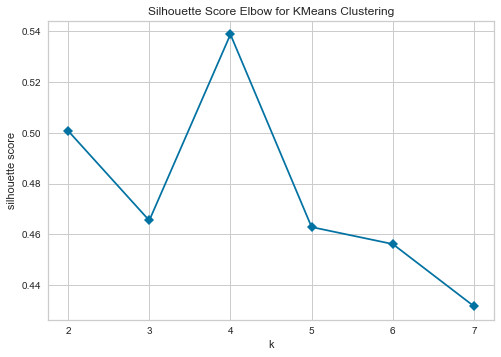

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [6]:
## taken from https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

# This is another elbow method visualization that is an alternative that's worth looking at. It recommends 2 clusters instead of 4, however.
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, metric='silhouette', locate_elbow = False, k=(2,8), timings=False)

visualizer.fit(average_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

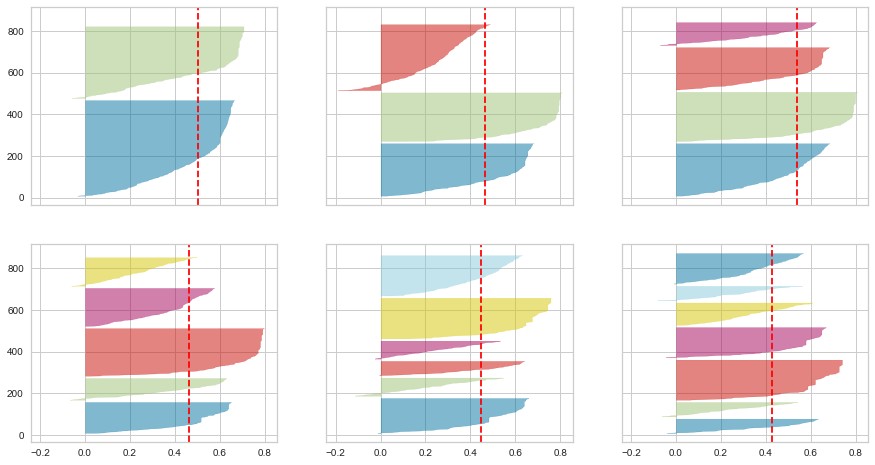

In [7]:
## taken from https://towardsdatascience.com/elbow-method-is-not-sufficient-to-find-best-k-in-k-means-clustering-fc820da0631d

from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
  
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i+1, 3)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(average_df)

The silhouette score is another method for determining the optimal number of clusters to partition a dataset into. Unlike the elbow method, the silhouette score considers how well clusters are seperated from other clusters. A higher score is better. The silhouette score is defined by averaging the silhouette coefficients of each data point. The silhouette coefficient is calculated by comparing the average distance of a data point from other data points in its cluster to the average distance of a data point from points in the nearest cluster. From the first graph we can see that the silhouette score peaks at 4. The second set of graphs illustrate that at 4 clusters the data is relatively evenly split between clusters, another desirable trait.

## Use K-means Clustering to Group First Four Treatments into Clusters

Here we view our combined dataset split into 4 clusters. An important note about the method we'll be using to compare cluster groups is that we'll fit our clusters on the combined dataset instead of retraining the cluster groups for each treatment. This allows for a more equal comparison between treatments by preventing the clusters from changing treatment to treatment.

In [59]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(trials_one_to_four[["pc","pd"]])

In [60]:
labels = kmeans.labels_
trials_one_to_four['clusters'] = labels+1

(0.0, 100.0)

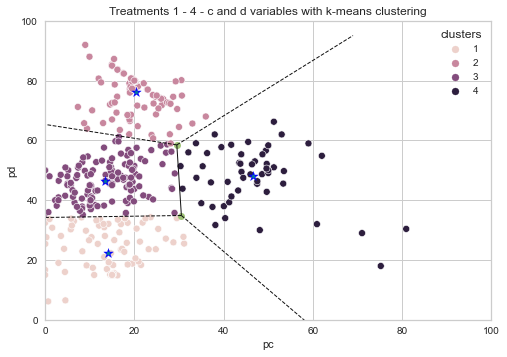

In [61]:
## Adapted from https://www.kaggle.com/code/zaldiego/mall-customers-clustering-kmeans-and-voronoi

centers = kmeans.cluster_centers_
vor = Voronoi(centers)
voronoi_plot_2d(vor)

sns.scatterplot(data = trials_one_to_four, x = 'pc', y = 'pd', hue='clusters').set(title='Treatments 1 - 4 - c and d variables with k-means clustering')

plt.scatter(centers[:, 0], centers[:, 1],c='blue', s=100, alpha=1, marker='*')
plt.ylim(0, 100)
plt.xlim(0, 100)

## Divide Data into Subsets by Treatment Groups

In [12]:
average_df_one = trials_one_to_four[trials_one_to_four["dataset"] == 1.0]
average_df_two = trials_one_to_four[trials_one_to_four["dataset"] == 2.0]
average_df_three = trials_one_to_four[trials_one_to_four["dataset"] == 3.0]
average_df_four = trials_one_to_four[trials_one_to_four["dataset"] == 4.0]

## Plot Subsets and Compare Number of Points in Original Clusters between Subsets

### Treatment 1

(0.0, 100.0)

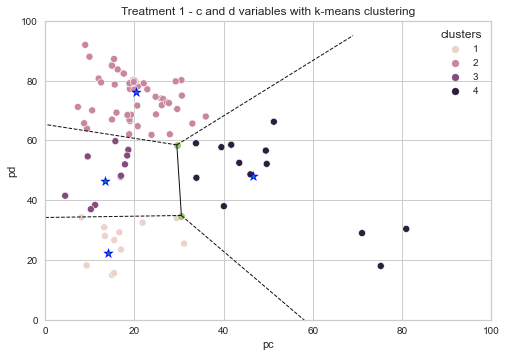

In [13]:
centers = kmeans.cluster_centers_
vor = Voronoi(centers)
voronoi_plot_2d(vor)

sns.scatterplot(data = average_df_one, x = 'pc', y = 'pd', hue='clusters').set(title='Treatment 1 - c and d variables with k-means clustering')

plt.scatter(centers[:, 0], centers[:, 1],c='blue', s=100, alpha=1, marker='*')
plt.ylim(0, 100)
plt.xlim(0, 100)

### Cluster Breakdown

1    12
2    66
3    10
4    13
Name: clusters, dtype: int64

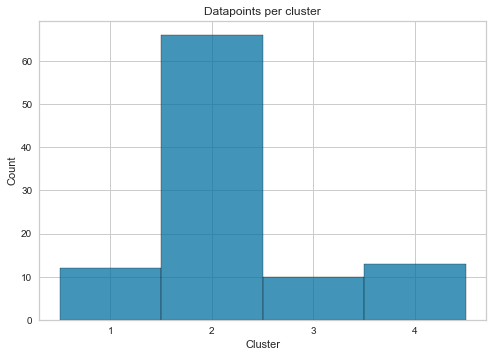

In [14]:
h = sns.histplot(average_df_one['clusters'], discrete=True)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Datapoints per cluster')

h.set_xticks([1, 2, 3, 4])

average_df_one['clusters'].value_counts().sort_index()

### Treatment 2

(0.0, 100.0)

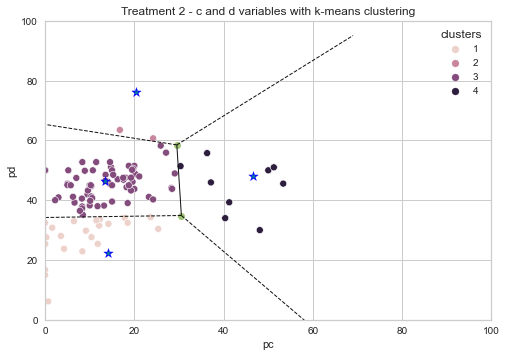

In [15]:
centers = kmeans.cluster_centers_
vor = Voronoi(centers)
voronoi_plot_2d(vor)

sns.scatterplot(data = average_df_two, x = 'pc', y = 'pd', hue='clusters').set(title='Treatment 2 - c and d variables with k-means clustering')

plt.scatter(centers[:, 0], centers[:, 1],c='blue', s=100, alpha=1, marker='*')
plt.ylim(0, 100)
plt.xlim(0, 100)

### Cluster Breakdown

1    23
2     2
3    67
4     9
Name: clusters, dtype: int64

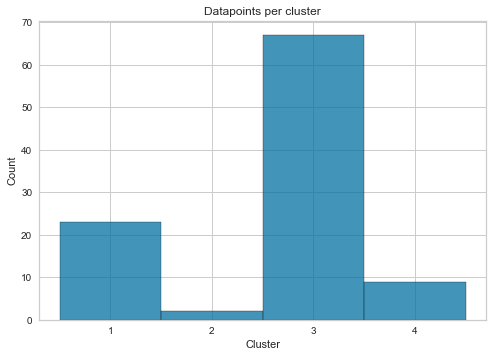

In [16]:
h = sns.histplot(average_df_two['clusters'], discrete=True)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Datapoints per cluster')

h.set_xticks([1, 2, 3, 4])

average_df_two['clusters'].value_counts().sort_index()

### Treatment 3

(0.0, 100.0)

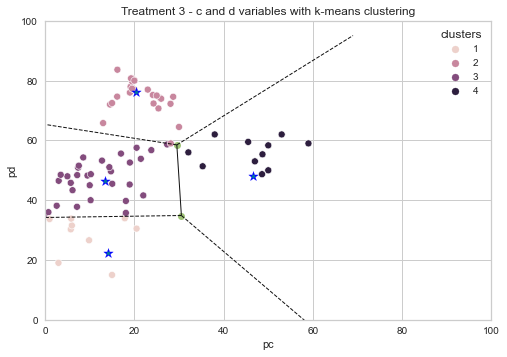

In [17]:
centers = kmeans.cluster_centers_
vor = Voronoi(centers)
voronoi_plot_2d(vor)

sns.scatterplot(data = average_df_three, x = 'pc', y = 'pd', hue='clusters').set(title='Treatment 3 - c and d variables with k-means clustering')

plt.scatter(centers[:, 0], centers[:, 1],c='blue', s=100, alpha=1, marker='*')
plt.ylim(0, 100)
plt.xlim(0, 100)

### Cluster Breakdown

1     9
2    49
3    32
4    11
Name: clusters, dtype: int64

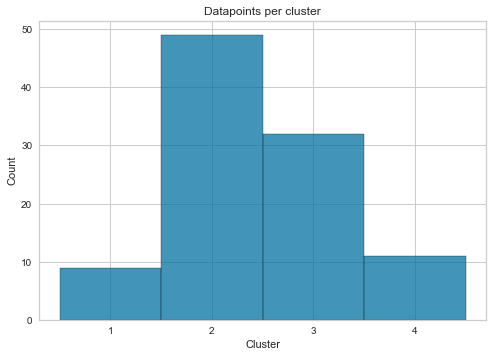

In [18]:
h = sns.histplot(average_df_three['clusters'], discrete=True)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Datapoints per cluster')

h.set_xticks([1, 2, 3, 4])

average_df_three['clusters'].value_counts().sort_index()

### Treatment 4

(0.0, 100.0)

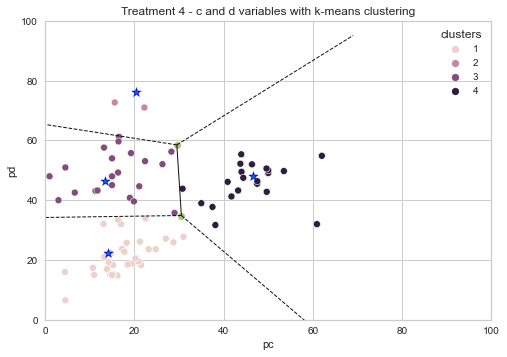

In [19]:
centers = kmeans.cluster_centers_
vor = Voronoi(centers)
voronoi_plot_2d(vor)

sns.scatterplot(data = average_df_four, x = 'pc', y = 'pd', hue='clusters').set(title='Treatment 4 - c and d variables with k-means clustering')

plt.scatter(centers[:, 0], centers[:, 1],c='blue', s=100, alpha=1, marker='*')
plt.ylim(0, 100)
plt.xlim(0, 100)

### Cluster Breakdown

1    56
2     2
3    21
4    21
Name: clusters, dtype: int64

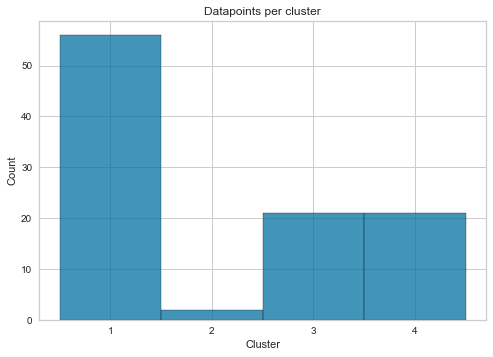

In [20]:
h = sns.histplot(average_df_four['clusters'], discrete=True)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Datapoints per cluster')

h.set_xticks([1, 2, 3, 4])

average_df_four['clusters'].value_counts().sort_index()

## Test Robustness with Treatments 5 - 8

In [22]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(trials_five_to_eight[["pc","pd"]])

In [23]:
labels = kmeans.labels_
trials_five_to_eight['clusters'] = (labels+1)

## These next few lines are because the clusters weren't labeled the same between when it is run on trials 1-4 and 5-8
## Use a dictionary to ensure the clusters are similar
cluster_dictionary ={1 : 2, 2 : 4, 3 : 1, 4 : 3}
trials_five_to_eight['correct_clusters'] = trials_five_to_eight['clusters'].map(cluster_dictionary)

trials_five_to_eight = trials_five_to_eight.drop(columns=['clusters'])
trials_five_to_eight = trials_five_to_eight.rename(columns={"correct_clusters": "clusters"})

(0.0, 100.0)

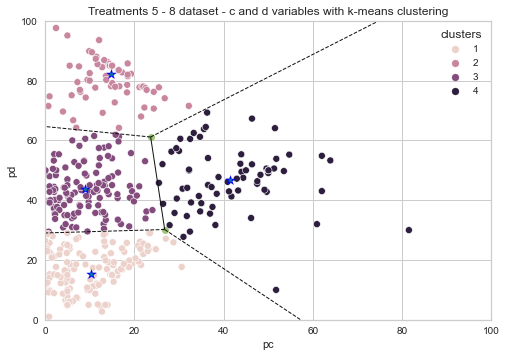

In [57]:
centers = kmeans.cluster_centers_
vor = Voronoi(centers)
voronoi_plot_2d(vor)

sns.scatterplot(data = trials_five_to_eight, x = 'pc', y = 'pd', hue='clusters').set(title='Treatments 5 - 8 dataset - c and d variables with k-means clustering')

plt.scatter(centers[:, 0], centers[:, 1],c='blue', s=100, alpha=1, marker='*')
plt.ylim(0, 100)
plt.xlim(0, 100)

In [25]:
average_df_five = trials_five_to_eight[trials_five_to_eight["dataset"] == 5.0]
average_df_six = trials_five_to_eight[trials_five_to_eight["dataset"] == 6.0]
average_df_seven = trials_five_to_eight[trials_five_to_eight["dataset"] == 7.0]
average_df_eight = trials_five_to_eight[trials_five_to_eight["dataset"] == 8.0]

## Treatment five

(0.0, 100.0)

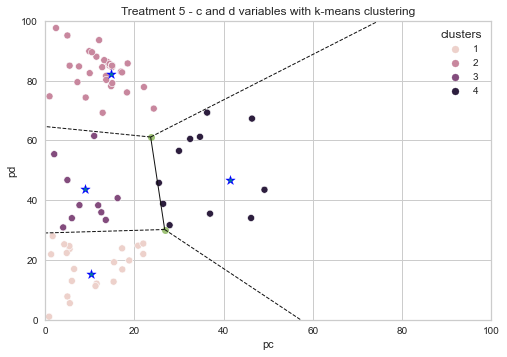

In [26]:
centers = kmeans.cluster_centers_
vor = Voronoi(centers)
voronoi_plot_2d(vor)

sns.scatterplot(data = average_df_five, x = 'pc', y = 'pd', hue='clusters').set(title='Treatment 5 - c and d variables with k-means clustering')

plt.scatter(centers[:, 0], centers[:, 1],c='blue', s=100, alpha=1, marker='*')
plt.ylim(0, 100)
plt.xlim(0, 100)

1    21
2    57
3    10
4    11
Name: clusters, dtype: int64

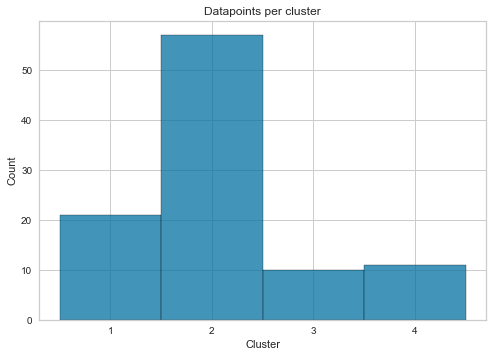

In [27]:
h = sns.histplot(average_df_five['clusters'], discrete=True)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Datapoints per cluster')

h.set_xticks([1, 2, 3, 4])

average_df_five['clusters'].value_counts().sort_index()

## Treatment six

(0.0, 100.0)

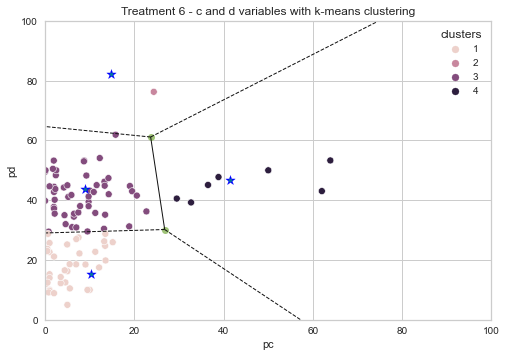

In [28]:
centers = kmeans.cluster_centers_
vor = Voronoi(centers)
voronoi_plot_2d(vor)

sns.scatterplot(data = average_df_six, x = 'pc', y = 'pd', hue='clusters').set(title='Treatment 6 - c and d variables with k-means clustering')

plt.scatter(centers[:, 0], centers[:, 1],c='blue', s=100, alpha=1, marker='*')
plt.ylim(0, 100)
plt.xlim(0, 100)

1    38
2     1
3    53
4     7
Name: clusters, dtype: int64

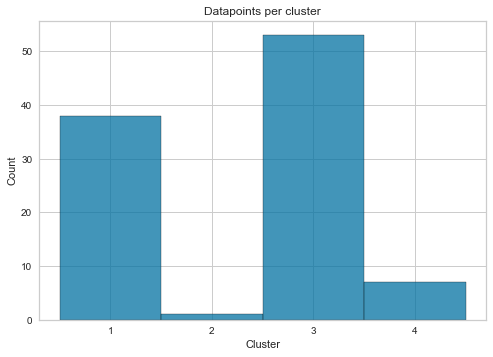

In [29]:
h = sns.histplot(average_df_six['clusters'], discrete=True)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Datapoints per cluster')

h.set_xticks([1, 2, 3, 4])

average_df_six['clusters'].value_counts().sort_index()

## Treatment seven

(0.0, 100.0)

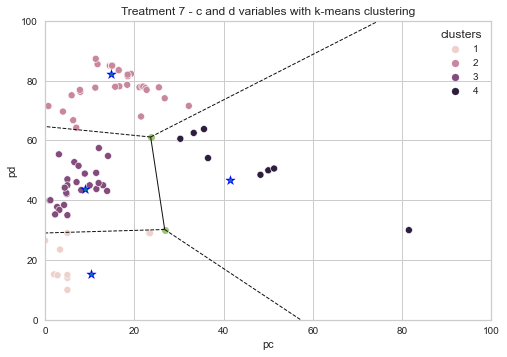

In [30]:
centers = kmeans.cluster_centers_
vor = Voronoi(centers)
voronoi_plot_2d(vor)

sns.scatterplot(data = average_df_seven, x = 'pc', y = 'pd', hue='clusters').set(title='Treatment 7 - c and d variables with k-means clustering')

plt.scatter(centers[:, 0], centers[:, 1],c='blue', s=100, alpha=1, marker='*')
plt.ylim(0, 100)
plt.xlim(0, 100)

1    10
2    58
3    26
4     8
Name: clusters, dtype: int64

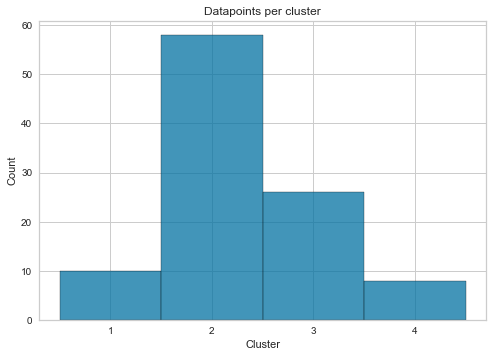

In [31]:
h = sns.histplot(average_df_seven['clusters'], discrete=True)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Datapoints per cluster')

h.set_xticks([1, 2, 3, 4])

average_df_seven['clusters'].value_counts().sort_index()

## Treatment eight

(0.0, 100.0)

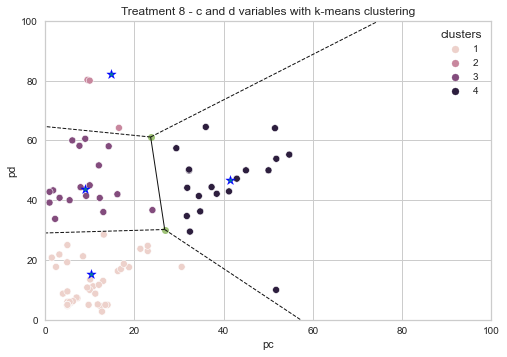

In [32]:
centers = kmeans.cluster_centers_
vor = Voronoi(centers)
voronoi_plot_2d(vor)

sns.scatterplot(data = average_df_eight, x = 'pc', y = 'pd', hue='clusters').set(title='Treatment 8 - c and d variables with k-means clustering')

plt.scatter(centers[:, 0], centers[:, 1],c='blue', s=100, alpha=1, marker='*')
plt.ylim(0, 100)
plt.xlim(0, 100)

1    60
2     3
3    18
4    19
Name: clusters, dtype: int64

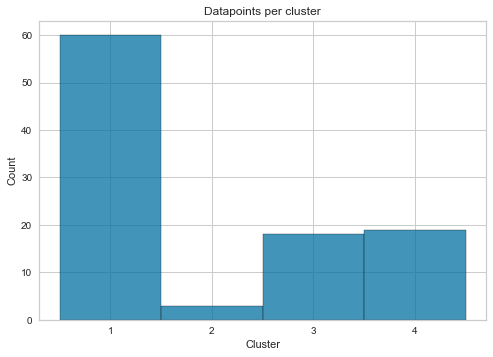

In [33]:
h = sns.histplot(average_df_eight['clusters'], discrete=True)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Datapoints per cluster')

h.set_xticks([1, 2, 3, 4])

average_df_eight['clusters'].value_counts().sort_index()

## Classify Data by Proximity to Predefined Centroids

Here datapoints are classified by their proximity to three predetermined centroids. These predetermined centroids represent the correct Bayesian probability, the naive probability, and a point equidistant between the two. These centroids are predetermined as they have an intuitive meaning. For example, more data points in the cluster associated with the correct Bayesian probability indicates less people falling victim to base rate bias. To calculate the nearest centroid from each data point we use 'cdist' from the scipy library to find the distance between each data point and each centroid. We then pick the centroid with the smallest distance.

### Treatments One to Four Together

(0.0, 100.0)

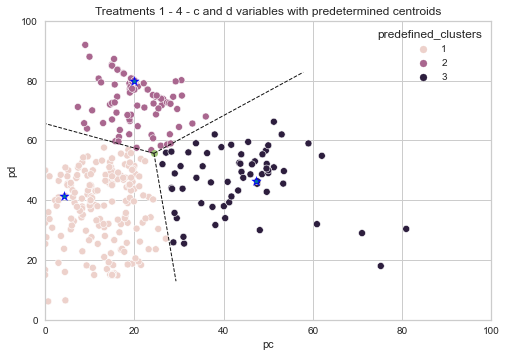

In [34]:
predefined_centroids = np.array([[4.23, 41.38], [20,80], [47.28,46.35]]) #Bayesian, Naive, and an Equidistant Point

# Calculate the distances between each data point and each centroid
distances = cdist(trials_one_to_four[["pc", "pd"]], predefined_centroids)

# Get the indices of the closest centroids for each data point
labels = np.argmin(distances, axis=1)
trials_one_to_four['predefined_clusters'] = labels+1

vor = Voronoi(predefined_centroids)
voronoi_plot_2d(vor)

sns.scatterplot(data = trials_one_to_four, x = 'pc', y = 'pd', hue='predefined_clusters').set(title='Treatments 1 - 4 - c and d variables with predetermined centroids')
plt.scatter(predefined_centroids[:, 0], predefined_centroids[:, 1],c='blue', s=100, alpha=1, marker='*')

plt.ylim(0, 100)
plt.xlim(0, 100)

1    212
2    126
3     65
Name: predefined_clusters, dtype: int64

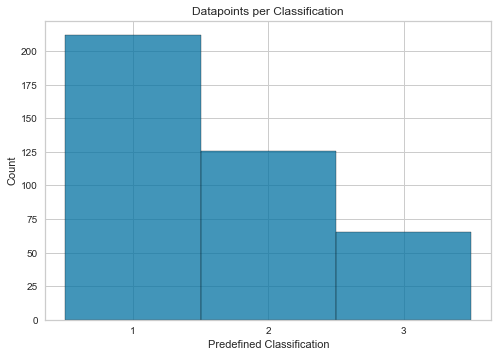

In [35]:
h = sns.histplot(trials_one_to_four['predefined_clusters'], discrete=True)
plt.xlabel('Predefined Classification')
plt.ylabel('Count')
plt.title('Datapoints per Classification')

h.set_xticks([1, 2, 3])

trials_one_to_four['predefined_clusters'].value_counts().sort_index()

In [36]:
average_df_one = trials_one_to_four[trials_one_to_four["dataset"] == 1.0]
average_df_two = trials_one_to_four[trials_one_to_four["dataset"] == 2.0]
average_df_three = trials_one_to_four[trials_one_to_four["dataset"] == 3.0]
average_df_four = trials_one_to_four[trials_one_to_four["dataset"] == 4.0]

### Treatment 1

(0.0, 100.0)

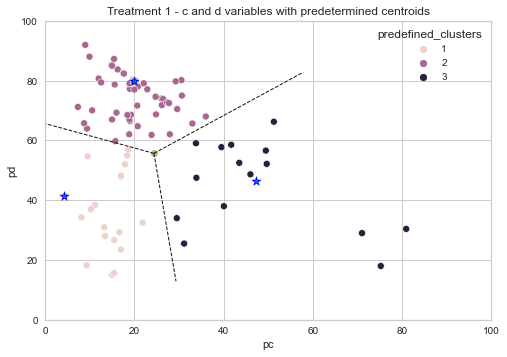

In [37]:
predefined_centroids = np.array([[4.23, 41.38], [20,80], [47.28,46.35]])
vor = Voronoi(predefined_centroids)
voronoi_plot_2d(vor)

sns.scatterplot(data = average_df_one, x = 'pc', y = 'pd', hue='predefined_clusters').set(title='Treatment 1 - c and d variables with predetermined centroids')
plt.scatter(predefined_centroids[:, 0], predefined_centroids[:, 1],c='blue', s=100, alpha=1, marker='*')

plt.ylim(0, 100)
plt.xlim(0, 100)

1    19
2    67
3    15
Name: predefined_clusters, dtype: int64

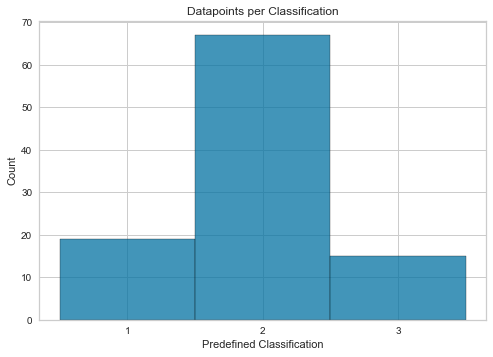

In [38]:
h = sns.histplot(average_df_one['predefined_clusters'], discrete=True)
plt.xlabel('Predefined Classification')
plt.ylabel('Count')
plt.title('Datapoints per Classification')

h.set_xticks([1, 2, 3])

average_df_one['predefined_clusters'].value_counts().sort_index()

### Treatment 2

(0.0, 100.0)

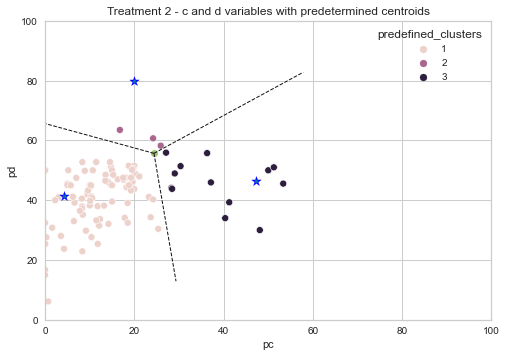

In [39]:
vor = Voronoi(predefined_centroids)
voronoi_plot_2d(vor)

sns.scatterplot(data = average_df_two, x = 'pc', y = 'pd', hue='predefined_clusters').set(title='Treatment 2 - c and d variables with predetermined centroids')
plt.scatter(predefined_centroids[:, 0], predefined_centroids[:, 1],c='blue', s=100, alpha=1, marker='*')

plt.ylim(0, 100)
plt.xlim(0, 100)

1    85
2     3
3    13
Name: predefined_clusters, dtype: int64

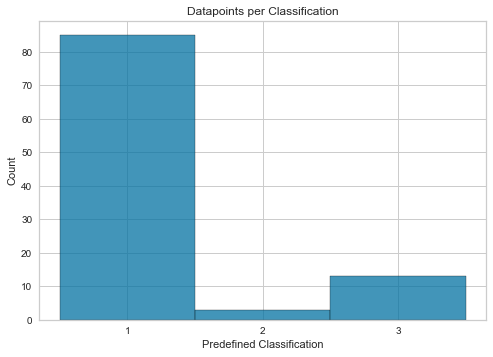

In [40]:
h = sns.histplot(average_df_two['predefined_clusters'], discrete=True)
plt.xlabel('Predefined Classification')
plt.ylabel('Count')
plt.title('Datapoints per Classification')

h.set_xticks([1, 2, 3])

average_df_two['predefined_clusters'].value_counts().sort_index()

### Treatment 3

(0.0, 100.0)

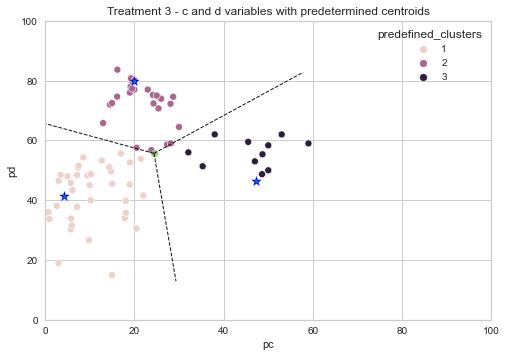

In [41]:
vor = Voronoi(predefined_centroids)
voronoi_plot_2d(vor)

sns.scatterplot(data = average_df_three, x = 'pc', y = 'pd', hue='predefined_clusters').set(title='Treatment 3 - c and d variables with predetermined centroids')
plt.scatter(predefined_centroids[:, 0], predefined_centroids[:, 1],c='blue', s=100, alpha=1, marker='*')

plt.ylim(0, 100)
plt.xlim(0, 100)

1    38
2    52
3    11
Name: predefined_clusters, dtype: int64

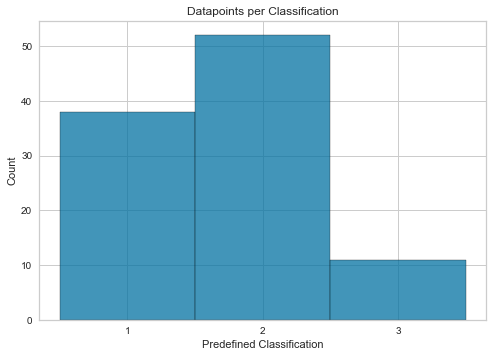

In [42]:
h = sns.histplot(average_df_three['predefined_clusters'], discrete=True)
plt.xlabel('Predefined Classification')
plt.ylabel('Count')
plt.title('Datapoints per Classification')

h.set_xticks([1, 2, 3])

average_df_three['predefined_clusters'].value_counts().sort_index()

### Treatment 4

(0.0, 100.0)

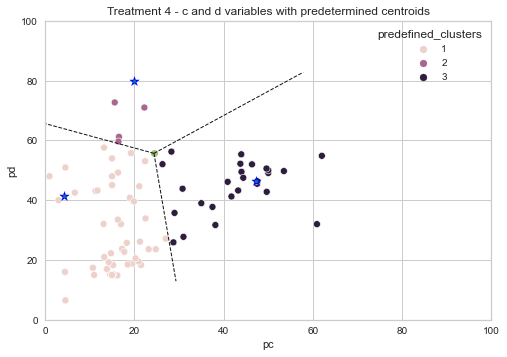

In [43]:
vor = Voronoi(predefined_centroids)
voronoi_plot_2d(vor)

sns.scatterplot(data = average_df_four, x = 'pc', y = 'pd', hue='predefined_clusters').set(title='Treatment 4 - c and d variables with predetermined centroids')
plt.scatter(predefined_centroids[:, 0], predefined_centroids[:, 1],c='blue', s=100, alpha=1, marker='*')

plt.ylim(0, 100)
plt.xlim(0, 100)

1    70
2     4
3    26
Name: predefined_clusters, dtype: int64

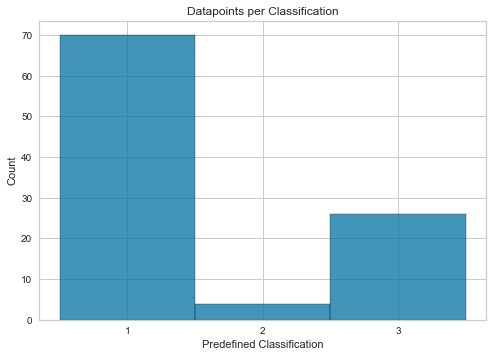

In [44]:
h = sns.histplot(average_df_four['predefined_clusters'], discrete=True)
plt.xlabel('Predefined Classification')
plt.ylabel('Count')
plt.title('Datapoints per Classification')

h.set_xticks([1, 2, 3])

average_df_four['predefined_clusters'].value_counts().sort_index()

### Treatment Five to Eight

(0.0, 100.0)

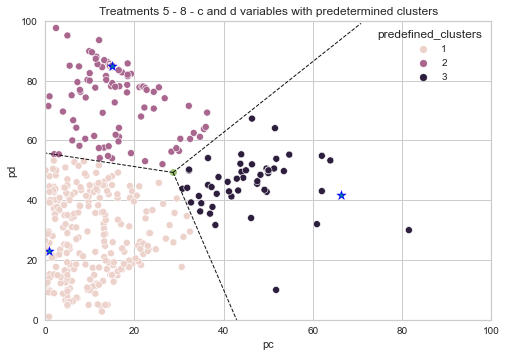

In [45]:
predefined_centroids = np.array([[0.92, 22.97], [15, 85], [66.18, 41.80]]) #Bayesian, Naive, and an Equidistant Point

# Calculate the distances between each data point and each centroid
distances = cdist(trials_five_to_eight[["pc", "pd"]], predefined_centroids)

# Get the indices of the closest centroids for each data point
labels = np.argmin(distances, axis=1)
trials_five_to_eight['predefined_clusters'] = labels+1

vor = Voronoi(predefined_centroids)
voronoi_plot_2d(vor)

sns.scatterplot(data = trials_five_to_eight, x = 'pc', y = 'pd', hue='predefined_clusters').set(title='Treatments 5 - 8 - c and d variables with predetermined clusters')

plt.scatter(predefined_centroids[:, 0], predefined_centroids[:, 1],c='blue', s=100, alpha=1, marker='*')

plt.ylim(0, 100)
plt.xlim(0, 100)

1    300
2    149
3     51
Name: predefined_clusters, dtype: int64

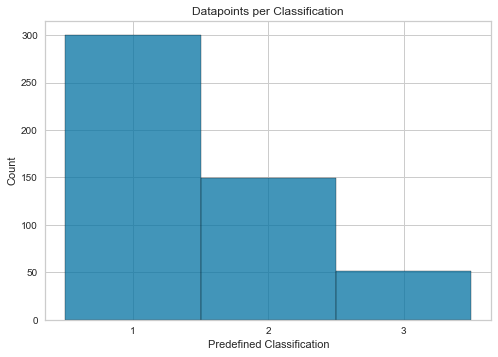

In [46]:
h = sns.histplot(trials_five_to_eight['predefined_clusters'], discrete=True)
plt.xlabel('Predefined Classification')
plt.ylabel('Count')
plt.title('Datapoints per Classification')

h.set_xticks([1, 2, 3])

trials_five_to_eight['predefined_clusters'].value_counts().sort_index()

In [47]:
average_df_five = trials_five_to_eight[trials_five_to_eight["dataset"] == 5.0]
average_df_six = trials_five_to_eight[trials_five_to_eight["dataset"] == 6.0]
average_df_seven = trials_five_to_eight[trials_five_to_eight["dataset"] == 7.0]
average_df_eight = trials_five_to_eight[trials_five_to_eight["dataset"] == 8.0]

### Treatment 5

(0.0, 100.0)

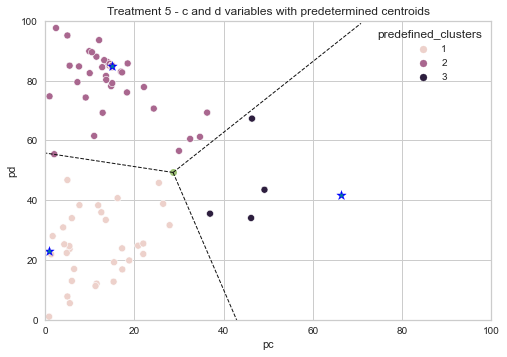

In [48]:
predefined_centroids = np.array([[0.92, 22.97], [15, 85], [66.18, 41.80]])

vor = Voronoi(predefined_centroids)
voronoi_plot_2d(vor)

sns.scatterplot(data = average_df_five, x = 'pc', y = 'pd', hue='predefined_clusters').set(title='Treatment 5 - c and d variables with predetermined centroids')
plt.scatter(predefined_centroids[:, 0], predefined_centroids[:, 1],c='blue', s=100, alpha=1, marker='*')

plt.ylim(0, 100)
plt.xlim(0, 100)

1    32
2    63
3     4
Name: predefined_clusters, dtype: int64

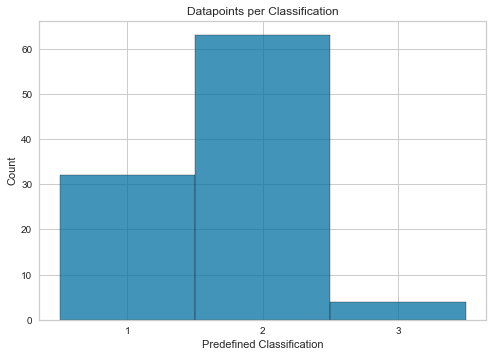

In [49]:
h = sns.histplot(average_df_five['predefined_clusters'], discrete=True)
plt.xlabel('Predefined Classification')
plt.ylabel('Count')
plt.title('Datapoints per Classification')

h.set_xticks([1, 2, 3])

average_df_five['predefined_clusters'].value_counts().sort_index()

### Treatment 6

(0.0, 100.0)

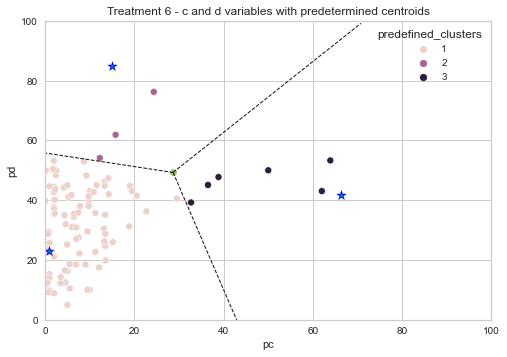

In [50]:
vor = Voronoi(predefined_centroids)
voronoi_plot_2d(vor)

sns.scatterplot(data = average_df_six, x = 'pc', y = 'pd', hue='predefined_clusters').set(title='Treatment 6 - c and d variables with predetermined centroids')
plt.scatter(predefined_centroids[:, 0], predefined_centroids[:, 1],c='blue', s=100, alpha=1, marker='*')

plt.ylim(0, 100)
plt.xlim(0, 100)

1    90
2     3
3     6
Name: predefined_clusters, dtype: int64

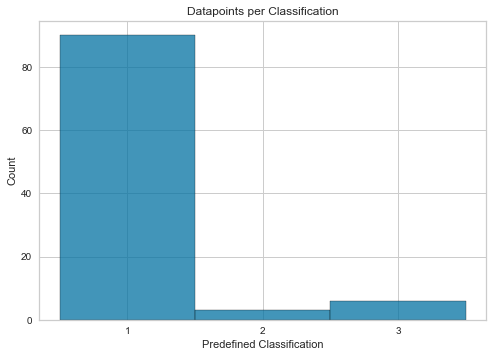

In [51]:
h = sns.histplot(average_df_six['predefined_clusters'], discrete=True)
plt.xlabel('Predefined Classification')
plt.ylabel('Count')
plt.title('Datapoints per Classification')

h.set_xticks([1, 2, 3])

average_df_six['predefined_clusters'].value_counts().sort_index()

### Treatment 7

(0.0, 100.0)

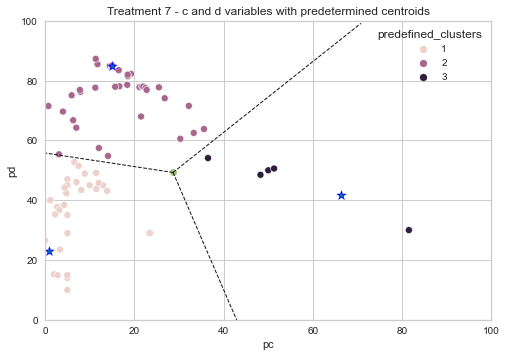

In [52]:
vor = Voronoi(predefined_centroids)
voronoi_plot_2d(vor)

sns.scatterplot(data = average_df_seven, x = 'pc', y = 'pd', hue='predefined_clusters').set(title='Treatment 7 - c and d variables with predetermined centroids')
plt.scatter(predefined_centroids[:, 0], predefined_centroids[:, 1],c='blue', s=100, alpha=1, marker='*')

plt.ylim(0, 100)
plt.xlim(0, 100)

1    33
2    64
3     5
Name: predefined_clusters, dtype: int64

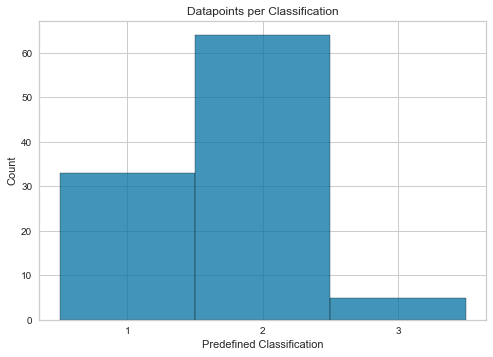

In [53]:
h = sns.histplot(average_df_seven['predefined_clusters'], discrete=True)
plt.xlabel('Predefined Classification')
plt.ylabel('Count')
plt.title('Datapoints per Classification')

h.set_xticks([1, 2, 3])

average_df_seven['predefined_clusters'].value_counts().sort_index()

### Treatment 8

(0.0, 100.0)

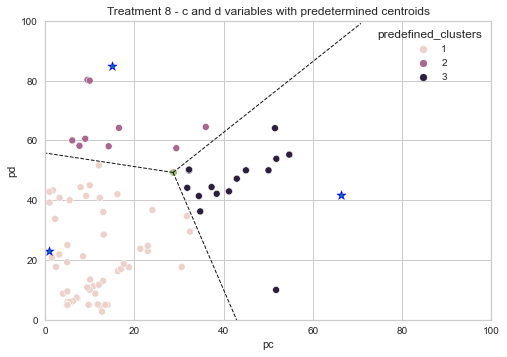

In [54]:
vor = Voronoi(predefined_centroids)
voronoi_plot_2d(vor)

sns.scatterplot(data = average_df_eight, x = 'pc', y = 'pd', hue='predefined_clusters').set(title='Treatment 8 - c and d variables with predetermined centroids')
plt.scatter(predefined_centroids[:, 0], predefined_centroids[:, 1],c='blue', s=100, alpha=1, marker='*')

plt.ylim(0, 100)
plt.xlim(0, 100)

1    76
2     9
3    15
Name: predefined_clusters, dtype: int64

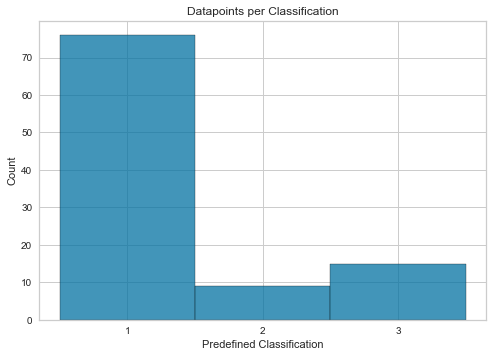

In [55]:
h = sns.histplot(average_df_eight['predefined_clusters'], discrete=True)
plt.xlabel('Predefined Classification')
plt.ylabel('Count')
plt.title('Datapoints per Classification')

h.set_xticks([1, 2, 3])

average_df_eight['predefined_clusters'].value_counts().sort_index()